# Experimenting with EDA and Modeling 

To start off, I'm going to focus all efforts on just NY. Once everything is up and running, I'll scale up to all 50 states.

In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pymongo
from pprint import pprint
%load_ext autoreload
%autoreload 2
%matplotlib inline

import helper_functions
import plotly.express as px
import plotly.graph_objects as go


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### First off, connect to MongoDB

In [4]:
client = pymongo.MongoClient('mongodb://localhost/')
db = client.admin

# Issue the serverStatus command and print the results
serverStatusResult=db.command("serverStatus")
pprint(serverStatusResult)

mydb = client['energy_data']


{'asserts': {'msg': 0, 'regular': 0, 'rollovers': 0, 'user': 25, 'warning': 0},
 'connections': {'active': 1,
                 'available': 3273,
                 'current': 3,
                 'totalCreated': 16},
 'electionMetrics': {'averageCatchUpOps': 0.0,
                     'catchUpTakeover': {'called': 0, 'successful': 0},
                     'electionTimeout': {'called': 0, 'successful': 0},
                     'freezeTimeout': {'called': 0, 'successful': 0},
                     'numCatchUps': 0,
                     'numCatchUpsAlreadyCaughtUp': 0,
                     'numCatchUpsFailedWithError': 0,
                     'numCatchUpsFailedWithNewTerm': 0,
                     'numCatchUpsFailedWithReplSetAbortPrimaryCatchUpCmd': 0,
                     'numCatchUpsSkipped': 0,
                     'numCatchUpsSucceeded': 0,
                     'numCatchUpsTimedOut': 0,
                     'numStepDownsCausedByHigherTerm': 0,
                     'priorityTakeover': {'c

In [5]:
print(client.list_database_names())

['admin', 'config', 'energy_data', 'local']


In [6]:
energy_collection = mydb['energy_data']

## Get NY Data, group the data by sector, including total (renewable vs. nonrenewable)

In [396]:
ny = [x for x in energy_collection.find({'state':'New York'})]

In [397]:
# Generate list of the possible sectors to iterate through
sectors = [series.get('sector') for series in ny]
sectors = list(set(sectors))
sectors.remove(None)
sectors.sort()

In [403]:
# Create a dictionary containing all of NY's dataframes
dataframes = {sector: helper_functions.get_energy_pop_df(ny,sector) for sector in sectors}

# Create a dataframe with just the temperature data
temp_df = helper_functions.get_weather_df(ny[1])

# Concatenate all these bad boys
for sector in dataframes:
    dataframes[sector] = pd.concat([dataframes[sector], temp_df],axis=1)

In [404]:
temp_df_melt = temp_df.reset_index().melt(id_vars='index',
                                value_vars=temp_column_titles,
                                var_name = 'Temperature Cutoff', 
                                value_name = 'Temperature')
temp_df_melt.columns = ['Year','Temperature Cutoff','Temperature']

In [405]:
for sector in sectors:
    helper_functions.plot_descriptive_fig(dataframes[sector], 
                                          ['Renewable Sources', 'Nonrenewable Sources'], 
                                          'NY',
                                          sector)

In [406]:
total_df = dataframes['Total All Sectors']

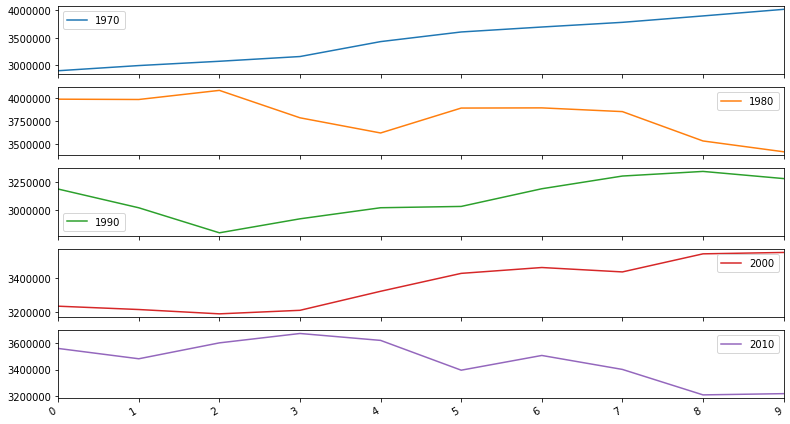

In [469]:
# Use pandas grouper to group values using annual frequency
nr_decade_groups = total_df['Nonrenewable Sources'].groupby(pd.Grouper(freq ='10Y'))

# Create a new DataFrame and store yearly values in columns 
total_decades = pd.DataFrame()

for yr, group in nr_decade_groups:
    if yr.year > 1960 and yr.year < 2011:
        total_decades[yr.year] = group.values
        

# Plot the yearly groups as subplots
total_decades.plot(figsize = (13,8), subplots=True);

In [470]:
decades_melt = total_decades.reset_index().melt(id_vars = 'index',
                                  value_vars = total_decades.columns,
                                  var_name = 'Decade',
                                  value_name = 'Energy Consumed (Billion Btu)')

decades_melt.columns = ['Year Within Decade', 'Decade', 'Energy Consumed (Billion Btu)'] 

fig = px.scatter(decades_melt,
              x = 'Year Within Decade',
              y = 'Energy Consumed (Billion Btu)',
              color = 'Decade',
              title = 'New York Nonrenewable Energy Consumption - Total All Sectors')
fig

In [267]:
fig = px.line(temp_df_melt, 
              x = 'Year', 
              y = 'Temperature', 
              color = 'Temperature Cutoff',
              title='New York Temperature Trends',
              height = 600,
              width = 1000)

fig.show()